In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_00 = pd.read_csv("dataset-of-00s.csv")
df_10 = pd.read_csv("dataset-of-10s.csv")
df_60 = pd.read_csv("dataset-of-60s.csv")
df_70 = pd.read_csv("dataset-of-70s.csv")
df_80 = pd.read_csv("dataset-of-80s.csv")
df_90 = pd.read_csv("dataset-of-90s.csv")

df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df = df.drop(axis=1, labels='time_signature')
#Scaling the data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

df_X = df.iloc[:,3:17]


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled


df_clean= df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]
#Removing outliers

df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

df_remove = df_clean.dropna()
#Removing missing values
df_remove.shape
#The number of songs remaining is 33401
df_merge = df.iloc[df_remove.index]
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])
df_merge.columns
#Removed the predictors that were not used from the original dataset

#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()


df_merge.iloc[:,3:15]
#creating final scaled data with all the variables
scale = StandardScaler()
scale_X = scale.fit_transform(df_merge.iloc[:,3:15])
df_merge.iloc[:,3:15] = scale_X

X = df_merge.iloc[:,3:15]
X.shape

y = df_merge['target']
y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
#print(X_train_final)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, X_val, y_train, y_val are already defined and are numpy arrays.

# Step 2: Create a RandomForestClassifier object
# Note: The parameters n_estimators, max_depth, and max_features should be similar to the ones you used in your from-scratch implementation for a fair comparison.
rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=5, max_features='sqrt')

# Step 3: Fit the model to your training data
rf_classifier.fit(X_train_final, y_train_final)

# Step 4: Predict the labels for your validation data
predictions_sklearn = rf_classifier.predict(X_valid)

# Step 5: Calculate the accuracy of the predictions
accuracy_sklearn = accuracy_score(y_valid, predictions_sklearn)
print(f"Accuracy of sklearn's RandomForest: {accuracy_sklearn:.2f}%")


Accuracy of sklearn's RandomForest: 0.70%


In [3]:
import numpy as np

# Helper function to compute Gini impurity
def gini_impurity(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    impurity = 1.0 - np.sum((counts / len(labels))**2)
    return impurity

# Function to perform a split on a node
def split_node(X, y, index, value):
    left_mask = X[:, index] <= value
    right_mask = X[:, index] > value
    return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

# Function to find unique values in a feature column
def unique_values(data):
    return np.unique(data)

# Best split based on Gini impurity
def get_best_split(X, y, n_features):
    best_feature, best_value, best_score, best_groups = None, None, float("inf"), None
    features = np.random.choice(X.shape[1], n_features, replace=False)
    for feature in features:
        values = unique_values(X[:, feature])
        for value in values:
            left_X, right_X, left_y, right_y = split_node(X, y, feature, value)
            if len(left_y) == 0 or len(right_y) == 0:
                continue
            gini = (gini_impurity(left_y) * len(left_y) + gini_impurity(right_y) * len(right_y)) / len(y)
            if gini < best_score:
                best_feature, best_value, best_score, best_groups = feature, value, gini, (left_X, right_X, left_y, right_y)
    return {'index': best_feature, 'value': best_value, 'groups': best_groups}

# Decision tree class
class DecisionTree:
    def __init__(self, max_depth, n_features):
        self.max_depth = max_depth
        self.n_features = n_features
        self.tree = None

    def _build_tree(self, X, y, depth):
        if len(np.unique(y)) == 1 or depth >= self.max_depth:
            return np.argmax(np.bincount(y))
        node = get_best_split(X, y, self.n_features)
        if not node['groups']:
            return np.argmax(np.bincount(y))
        left_X, right_X, left_y, right_y = node['groups']
        return {'feature_index': node['index'], 'threshold': node['value'],
                'left': self._build_tree(left_X, left_y, depth + 1),
                'right': self._build_tree(right_X, right_y, depth + 1)}

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _predict_one(self, observation, tree):
        if not isinstance(tree, dict):
            return tree
        if observation[tree['feature_index']] <= tree['threshold']:
            return self._predict_one(observation, tree['left'])
        else:
            return self._predict_one(observation, tree['right'])

    def predict(self, X):
        return [self._predict_one(x, self.tree) for x in X]

# Random Forest class
class RandomForest:
    def __init__(self, n_trees, max_depth, n_features):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.n_features = n_features
        self.forest = []

    def fit(self, X, y):
        self.forest = []
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), len(X), replace=True)
            tree = DecisionTree(self.max_depth, self.n_features)
            tree.fit(X[indices], y[indices])
            self.forest.append(tree)

    def predict(self, X):
        tree_preds = [tree.predict(X) for tree in self.forest]
        predictions = np.array([np.argmax(np.bincount(preds)) for preds in np.array(tree_preds).T])
        return predictions


# Function to calculate accuracy
def accuracy_metric(actual, predicted):
    correct = np.sum(actual == predicted)
    return correct / len(actual) * 100


In [4]:
# Convert pandas DataFrames to numpy arrays
X_train_np = X_train_final.to_numpy()
y_train_np = y_train_final.to_numpy()
X_valid_np = X_valid.to_numpy()
y_valid_np = y_valid.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

# Define hyperparameters
n_trees = 10
max_depth = 5
n_features = int(np.sqrt(X_train_np.shape[1]))

# Initialize and train the random forest model
rf_model = RandomForest(n_trees=n_trees, max_depth=max_depth, n_features=n_features)
rf_model.fit(X_train_np, y_train_np)

# Make predictions
y_pred_train = rf_model.predict(X_train_np)
y_pred_valid = rf_model.predict(X_valid_np)
y_pred_test = rf_model.predict(X_test_np)

# Calculate accuracy
train_accuracy = accuracy_metric(y_train_np, y_pred_train)
valid_accuracy = accuracy_metric(y_valid_np, y_pred_valid)
test_accuracy = accuracy_metric(y_test_np, y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", valid_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 70.08982035928145
Validation Accuracy: 68.47305389221557
Test Accuracy: 68.44783715012723


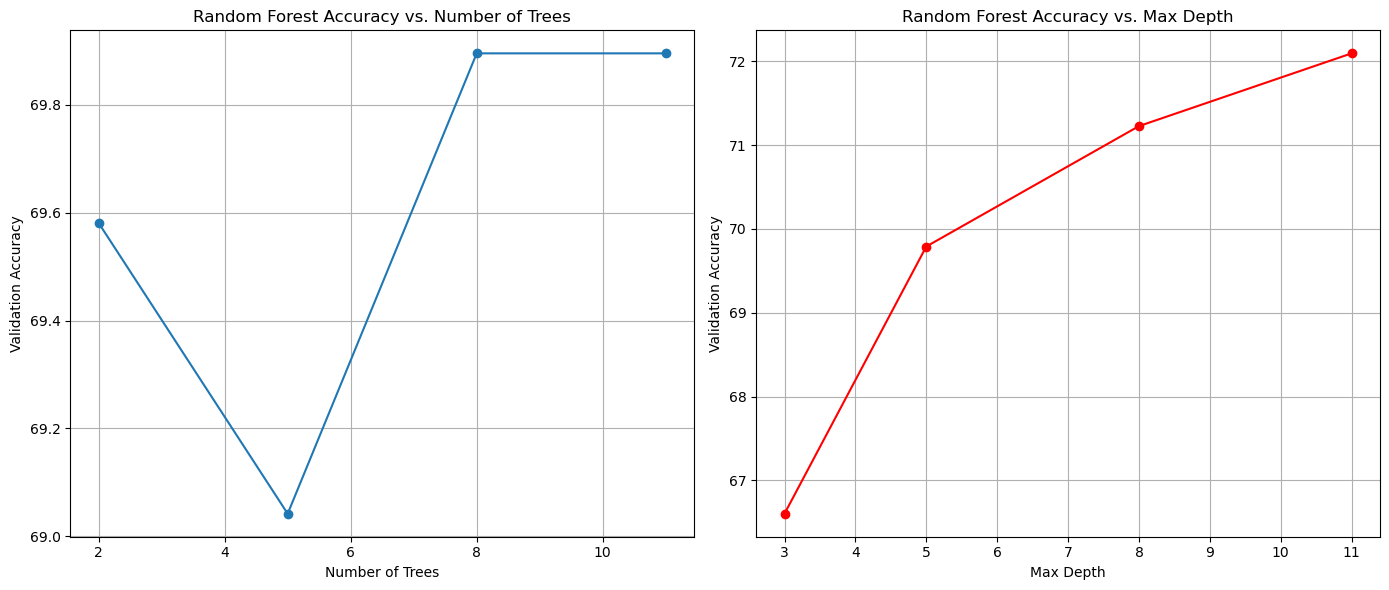

In [7]:
import matplotlib.pyplot as plt
'''
# Function to calculate accuracy
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
'''
# Initialize lists to store the accuracies for each hyperparameter setting
tree_accuracies = []
depth_accuracies = []

# Testing different numbers of trees
tree_range = [2, 5, 8, 11]
for n_trees in tree_range:
    rf_model = RandomForest(n_trees=n_trees, max_depth=5, n_features=n_features)
    rf_model.fit(X_train_np, y_train_np)
    y_pred_valid = rf_model.predict(X_valid_np)
    accuracy = accuracy_metric(y_valid_np, y_pred_valid)
    tree_accuracies.append(accuracy)

# Testing different maximum depths
depth_range = [3, 5, 8, 11]
for max_depth in depth_range:
    rf_model = RandomForest(n_trees=10, max_depth=max_depth, n_features=n_features)
    rf_model.fit(X_train_np, y_train_np)
    y_pred_valid = rf_model.predict(X_valid_np)
    accuracy = accuracy_metric(y_valid_np, y_pred_valid)
    depth_accuracies.append(accuracy)

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(tree_range, tree_accuracies, marker='o')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Validation Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(depth_range, depth_accuracies, marker='o', color='red')
plt.title('Random Forest Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
